# Lab 2 : Working with Recurrent Neural Networks

---


Total Points: **100**

Tentative Weightage : **10%**

Submission Deadline :  **31st October 2020, 23:59 hours**

---



General Instructions:

---



1. You have to do this lab individually
2. You may use either **Tensorflow 2.x or PyTorch** framework
3. Please start early as the experiments may take time to run
4. All the code should be submitted in the form of a single Jupyter notebook itself.
5. Points for each sub-section are mentioned in the appropriate question.
6. You can use Google colab to run a jupyter notebook (https://colab.research.google.com/) How to load data in Google Colab ?(https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92) (https://www.marktechpost.com/2019/06/07/how-to-connect-google-colab-with-google-drive/)
7. The lab must be submitted on Google classroom. The code as well as the accompanying observations should be made part of the python notebook.
8. **Code Readability** is very important. Modularize your code by making use of classes, functions that can be flexibly reused wherever necessary. Also use self explanatory variable names and add comments to describe your approach wherever necessary. You may add additional code or text blocks as necessary.
9. You are expected to submit your **detailed inferences** (preferably in a text block) and not just an error free code.
10. Students are expected to follow the **honor code** of the class.

In [1]:
#mount gdrive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [296]:
# Import the necessary libraries
import numpy as np
import re
import tensorflow as tf
import random
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

# Basic Linear Recurrent Neural Network from Scratch (Total for this subsection: **30 points**)
---
This section aims to design a simple one hidden layer RNN from scratch to count the number of ones in a binary sequence ( e.g., number of ones in  [ 1, 1, 1, 0, 0, 1, 0, 0, 1, 1] is 6) 

*   The structure of RNN and corresponding equations are given as follows:


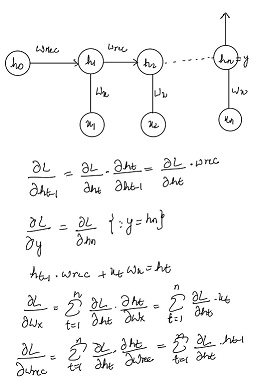


*   Since the update equations have been worked out, we are ready to implement.
---
Note 1: There are no non-linear activation functions in this architecture to make backpropagation of gradients simple.

Note 2: The last timestamp's hidden state is the output of the network.






# Synthetic Dataset

In [416]:
# Following code snippet generates a binary sequence.  
num_samples = 25
sequence_len = 10
# Sequences
dataset = np.zeros((num_samples, sequence_len))
for row_idx in range(num_samples):
    dataset[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Targets
labels = np.sum(dataset, axis=1)

test_dataset = np.zeros((num_samples, sequence_len))

for row_idx in range(num_samples):
    test_dataset[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)
# Targets
test_labels = np.sum(test_dataset, axis=1)

# To do:
---
* Perform forward and backward pass. You **cannot** use gradient tape in TensorFlow (or equivalent in PyTorch). **(4+6 = 10 points)**
* Use mean square error for computing loss and plot the mesh-grid of the loss surface (w_x vs. w_rec). **(3 points)**
* On this loss surface, mark points (w_x, w_rec) that show exploding and vanishing gradients property. **(2 points)**
*  Give an insight into the instability of gradients during backward propagation on a graph. Plot a graph between gradients of loss w.r.t hidden state at time t (Y-axis) and timestamps t (X-axis). Note that you have to plot for various (w_x, w_rec) showing peculiar properties from the previous question. Mark your observations.  **(5 + 3 = 8 points)**
* Use Rprop (Resilient Propagation) as an optimization algorithm; you can use the library (if any) for this part. **(3 points)**
* Plot the optimization trajectory on the loss surface. **(2 points)**
* Is your RNN well trained? Does it count the number of ones in the binary list well? How significant a change is observed in model training by introduction of Resilient Propoagation? **(2 points)**



#  Simple RNN
**Paramter Initialization** 
* w_x   = -1.5
* w_rec = 2
* h_0   = 0








######Parameter Initialisation

In [439]:
# #initialise the paramters of the network
w_x = -1.5
w_rec = 2
lr = 1e-8

######Functions for simple rnn

In [480]:
#y is the actual output
def get_loss(y, y_label):
  return (y-y_label)**2

#y is the actual output
def get_dl_dy(y, y_label):
  return 2*(y-y_label)

#get gradient of loss wrt previous timestep given the gradient wrt current timestep 
def get_dl_dht_minus_one(dl_dht, w_rec_=w_rec):
  # print(dl_dht, w_rec)
  return dl_dht*w_rec_

#get h_t from ht-1 and x_t
def get_ht(ht_minus_one, x_t, w_rec_=w_rec, w_x_=w_x):
  return ht_minus_one*w_rec_ + x_t*w_x_

def get_dl_dw_x(dl_dht, x_t):
  #index of t[1...n]
  return np.sum(np.multiply(dl_dht, x_t))

def get_dl_dw_rec(dl_dht, ht_minus_1):
  #index of t[1...n]
  return np.sum(np.multiply(dl_dht, ht_minus_1))


def forward_pass(h_t_mat_, x_, w_rec_=w_rec, w_x_=w_x):#h_t = x_t*w_x + h_(t-1) * w_rec
  h_t_mat_[0]=0 
  for t in range(1, T+1):
    h_t_mat_[t] = get_ht(h_t_mat_[t-1], x_[t-1], w_rec_=w_rec_, w_x_=w_x_)
  return h_t_mat_[T], h_t_mat_

In [481]:
#number of timesteps in input
T = dataset.shape[1]
h_t_mat = np.zeros(T+1)
dl_dht_mat = np.zeros(T+1)

####Do a forward and backward pass and train using simple gradient descent

######Train

In [482]:
for epoch in tqdm(range(10)):  
  for x in dataset:
    #do a forward pass through the network
    y_label = np.sum(x)
    y, h_t_mat = forward_pass(h_t_mat, x, w_rec_=w_rec, w_x_=w_x)

    #do the backward pass now for this x
    #compute the loss 
    loss = get_loss(y, y_label)


    #compute the gradients
    dl_dht_mat[T] = get_dl_dy(y, y_label)
    for t in reversed(range(0, T)):
      dl_dht_mat[t] = get_dl_dht_minus_one(dl_dht=dl_dht_mat[t+1])


    dl_dw_x = get_dl_dw_x(dl_dht_mat[1:], x)
    dl_dw_rec = get_dl_dw_rec(dl_dht_mat[1:], h_t_mat[:-1])

    # update the paramters
    w_x = w_x - lr*dl_dw_x
    w_rec = w_rec - lr*dl_dw_rec

    h_t_mat = np.zeros(T+1)
    dl_dht_mat = np.zeros(T+1)



100%|██████████| 10/10 [00:00<00:00, 432.60it/s]


In [483]:
print("w_x: {}; w_rec: {};".format(w_x, w_rec))

w_x: 1.0426589424670023; w_rec: 0.9918734032101214;


######Test

In [484]:
def test_simple_rnn(test_dataset_, w_rec_, w_x_):
  correct=0
  for x in test_dataset_:
    y_pred, _ = forward_pass(h_t_mat, x, w_rec_, w_x_)
    y_pred = np.around(y_pred)
    y_label = np.sum(x)
    if y_label==y_pred:
      correct+=1
  total_count = test_dataset.shape[0]
  return (correct/total_count)*100.0

In [485]:
print("Test Accuracy is {}".format(test_simple_rnn(test_dataset, w_rec, w_x) ))

Test Accuracy is 100.0


######Use mean square error for computing loss and plot the mesh-grid of the loss surface

In [324]:
def compute_average_loss(w_rec_temp, w_x_temp):
  loss = 0
  for x in dataset:
    h_t_mat_temp = np.zeros(T+1)
    y_pred, _ = forward_pass(h_t_mat_temp, x, w_rec_=w_rec_temp, w_x_=w_x_temp)
    loss+=get_loss(y_pred, np.sum(x))
  loss = loss/(float)(X.shape[0])
  return loss

In [493]:
def plot_graph(x_range, y_range, funx, start_point=None, points=[(1,2)], end_point=None,  resolution=0.25):
  w_x_range = np.arange(x_range[0], x_range[1], 0.25)
  w_rec_range = np.arange(y_range[0], y_range[1], 0.25)

  vectorize_loss_fn = np.vectorize(funx)

  X_graph, Y_graph = np.meshgrid(w_x_range, w_rec_range)
  Z_graph = vectorize_loss_fn(Y_graph, X_graph)

  fig = plt.figure(figsize=(12, 12))
  ax = fig.gca(projection='3d')
  surf = ax.plot_surface(X_graph, Y_graph, Z_graph, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha=0.6)

  for point in points:
    plt.plot([point[0]], [point[1]])
  
  plt.show()

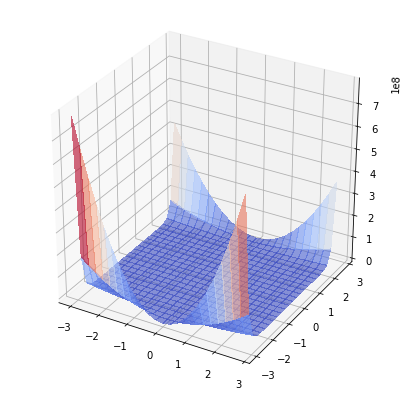

In [494]:
plot_graph([-3,3], [-3,3], compute_average_loss)

####Use Rprop

######Train

In [476]:
#initialise the paramters of the network
w_x_rp = -1.5
w_rec_rp = 2.0

step_size_w_x_rp = 1e-2
step_size_w_rec_rp = 1e-2

step_size_w_x_prev_rp = 1e-2
step_size_w_rec_prev_rp = 1e-2

alpha_rp = 0.5
beta_rp = 1.2

step_size_max_rp = 1e-1
step_size_min_rp = 1e-3

dl_dw_rec_prev_rp = 1.0
dl_dw_x_prev_rp = 1.0


In [477]:
#number of timesteps in input
T_rp = dataset.shape[1]
h_t_mat_rp = np.zeros(T_rp+1)
dl_dht_mat_rp = np.zeros(T_rp+1)

In [478]:
for epoch_rp in tqdm(range(2)):
  for x_rp in dataset:
    y_label_rp = np.sum(x_rp)
    #do a forward pass through the network
    y_rp, h_t_mat_rp = forward_pass(h_t_mat_rp, x_rp, w_rec_=w_rec_rp, w_x_=w_x_rp)

    #do the backward pass now for this x
    #compute the loss 
    loss = get_loss(y_rp, y_label_rp)

    #compute the gradients
    dl_dht_mat_rp[T_rp] = get_dl_dy(y_rp, y_label_rp)
    for t in reversed(range(0, T_rp)):
      dl_dht_mat_rp[t] = get_dl_dht_minus_one(dl_dht=dl_dht_mat_rp[t+1], w_rec_=w_rec_rp)


    dl_dw_x_rp = get_dl_dw_x(dl_dht_mat_rp[1:], x_rp)
    dl_dw_rec_rp = get_dl_dw_rec(dl_dht_mat_rp[1:], h_t_mat_rp[:-1])


    # update the w_x paramter using the rprop rule
    if dl_dw_x_rp*dl_dw_x_prev_rp>0:
      step_size_w_x_rp = min(step_size_w_x_prev_rp*beta_rp, step_size_max_rp)
    elif dl_dw_x_rp*dl_dw_x_prev_rp<0:
      step_size_w_x_rp = max(step_size_w_x_prev_rp*alpha_rp, step_size_min_rp)
    else:
      step_size_w_x_rp = step_size_w_x_prev_rp

    #update the w_rec paramter using the rprop rule
    if dl_dw_rec_rp*dl_dw_rec_prev_rp>0:
      step_size_w_rec_rp = min(step_size_w_rec_prev_rp*beta_rp, step_size_max_rp)
    elif dl_dw_rec_rp*dl_dw_rec_prev_rp<0:
      step_size_w_rec_rp = max(step_size_w_rec_prev_rp*alpha_rp, step_size_min_rp)
    else:
      step_size_w_rec_rp = step_size_w_rec_prev_rp


    w_x_rp = w_x_rp - step_size_w_x_rp*np.sign(dl_dw_x_rp)
    w_rec_rp = w_rec_rp - step_size_w_rec_rp*np.sign(dl_dw_rec_rp)


    step_size_w_x_prev_rp   = step_size_w_x_rp 
    step_size_w_rec_prev_rp = step_size_w_rec_rp 
    dl_dw_rec_prev_rp = dl_dw_rec_rp
    dl_dw_x_prev_rp = dl_dw_x_rp

    h_t_mat_rp = np.zeros(T_rp+1)
    dl_dht_mat_rp = np.zeros(T_rp+1)

    print("Epoch-->{}; Loss-->{};".format(epoch_rp, loss))


100%|██████████| 2/2 [00:00<00:00, 204.02it/s]

Epoch-->0; Loss-->1399489.0;
Epoch-->0; Loss-->1192060.2415779773;
Epoch-->0; Loss-->1442600.8754987703;
Epoch-->0; Loss-->11400.16435169189;
Epoch-->0; Loss-->1247188.6349684224;
Epoch-->0; Loss-->998445.6700276005;
Epoch-->0; Loss-->402376.858309517;
Epoch-->0; Loss-->316734.79725434695;
Epoch-->0; Loss-->192045.21432558354;
Epoch-->0; Loss-->212366.43131680455;
Epoch-->0; Loss-->81607.82519152225;
Epoch-->0; Loss-->14650.566051196367;
Epoch-->0; Loss-->1183.9795616148303;
Epoch-->0; Loss-->1102.9149206368322;
Epoch-->0; Loss-->477.9415573234123;
Epoch-->0; Loss-->191.75113340872363;
Epoch-->0; Loss-->179.99490853196718;
Epoch-->0; Loss-->154.7182600759322;
Epoch-->0; Loss-->50.53942294905307;
Epoch-->0; Loss-->69.14380255648938;
Epoch-->0; Loss-->40.659934279509265;
Epoch-->0; Loss-->4.139354567756172;
Epoch-->0; Loss-->12.970293784310178;
Epoch-->0; Loss-->25.37217458131832;
Epoch-->0; Loss-->29.118625740927524;
Epoch-->1; Loss-->16.311680317023953;
Epoch-->1; Loss-->4.000000018910

######Test

In [479]:
print("Test Accuracy is {}".format(test_simple_rnn(test_dataset, w_rec_rp, w_x_rp) ))

Test Accuracy is 100.0


# Machine Translation

---
In this section we will use the modified RNN's (LSTM or GRU) which can overcome the shortcomings of the multi layer Vanilla RNN for the Machine Translation task. We will be using the Hindi - English sentence pairs dataset for this exercise. The dataset can be downloaded from [Kaggle link](https://www.kaggle.com/kkhandekar/hindi-english-sentence-pairs) 












# To do

---
## Data Preprocessing (Total for this subsection : 10 points)

---


1. For ease of implementation, convert all English characters to either lower case or upper case **(1 point)**
2. Replace punctuations by spaces **(1 point)**
3. Add \<start\> token to the begin of each sentence (both English and Hindi) **(1 point)**
4. Add \<end\> token to the end of each sentence (both English and Hindi) **(1 point)**
5. Use a built in library tokenizer to convert words to tokens (numeric representation) (both English and Hindi) **(2 points)**
6. Use \<pad\> token so that all statements of a language has same length **(1 point)**
7. Convert a random instance from token sequence into words and display the human readable words (both English and Hindi) **(2 points)**
8. Split the dataset in 80%/20% split to get train and test sets **(1 point)**


## Model Architecture

---

In general machine translation systems use two RNN's commonly called as Encoder and Decoder. Encoder works on the input language sequence and converts it into a hidden representation on which decoder works. Decoder is responsible for generating the target language sequence. Attention mechanism is used to learn which parts of the input sequence is to be looked at in order to generate the translation in the target language. 

**Note:** You may use LSTM or GRU or any special layers of your choice

## Translator Model (Total for this subsection : 60 points)

---

1. We will be doing a English to Hindi translation task
2. Design a suitable encoder architecture to process the input sequences in English **(15 points)**
3. Use the attention Mechanism by Bahdanau et al. [1] to learn the effective alignment between English and Hindi sequences **(15 points)**
4. Design a suitable decoder architecture which can generate the target Hindi sequence based on the soft aligned English sequence **(15 points)**
5. Train the encoder-decoder sequence based on the cross entropy loss **(10 points)**
6. Use the BLEU score metric (pre defined library implementations in Python may be used) and discuss the goodness of the learned translator model **(5 points)**


### Reference:
[1] Dzmitry Bahdanau, KyungHyun Cho, Yoshua Bengio , "Neural Machine Translation
By Jointly Learning To Align And Translate", ICLR 2015


In [ ]:
#Data preprocessing
BASE_PATH = '/gdrive/My Drive/ANN/lab_2/'
DATA_PATH = BASE_PATH + 'training_data/hin.txt'
CHECKPOINT_DIR = BASE_PATH + 'checkpoints/'

In [ ]:
PAD_TOKEN = " \<pad>"

In [ ]:
ENGLISH_DATA =[]
HINDI_DATA = []

MAX_LENGTH = 0

with open(DATA_PATH, 'r') as f:
  lines = f.readlines()
  for line in lines:
    split_line = line.split(sep='\t')
    english_line = split_line[0].lower() #convert all english letters to lower case
    english_line = english_line.replace('\"', '')
    english_line = english_line.replace(',', '')
    english_line = english_line.replace('.', '')
    english_line = english_line.replace('?', '')
    english_line.strip()
    english_line = re.sub('\s+', ' ', english_line) 

    if english_line=='Do you like this book':
      print(english_line)

    english_line = "\<start> " + english_line + " \<end>"

    hindi_line = split_line[1]
    hindi_line = hindi_line.replace('\"', '')
    hindi_line = hindi_line.replace(',', '')
    hindi_line = hindi_line.replace('.', '')
    hindi_line = hindi_line.replace('?', '')
    hindi_line.strip()
    hindi_line = re.sub('\s+', ' ', hindi_line) 

    hindi_line = "\<start> " + hindi_line + " \<end>"

    ENGLISH_DATA.append(english_line)
    HINDI_DATA.append(hindi_line)

    MAX_LENGTH = max(MAX_LENGTH, max(len(english_line.split(sep=' ')), len(hindi_line.split(sep=' '))))
    # MAX_LENGTH = max(MAX_LENGTH, len(english_line.split(sep=' ')))

    
#pad each line with so that every line is equal to MAX_LENGTH
for i in range(len(ENGLISH_DATA)):
  line = ENGLISH_DATA[i]
  num_pads = MAX_LENGTH-len(line.split(sep=' '))
  ENGLISH_DATA[i] = line + PAD_TOKEN*num_pads

for i in range(len(HINDI_DATA)):
  line = HINDI_DATA[i]
  line = re.sub('\s+', ' ', line)
  num_pads = MAX_LENGTH-len(line.split(sep=' '))
  HINDI_DATA[i] = line + PAD_TOKEN*num_pads

In [ ]:
print(MAX_LENGTH)

27


In [ ]:
#define an instance of the tokenizer class for english
english_tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', filters='')
english_tokenizer.fit_on_texts(ENGLISH_DATA)
english_tokens = english_tokenizer.texts_to_sequences(ENGLISH_DATA)
english_tokens = np.array(english_tokens)

#define an instance of the tokenizer class for hindi
hindi_tokenizer = tf.keras.preprocessing.text.Tokenizer(split=' ', filters='')
hindi_tokenizer.fit_on_texts(HINDI_DATA)
hindi_tokens = hindi_tokenizer.texts_to_sequences(HINDI_DATA)
hindi_tokens = np.array(hindi_tokens)


In [ ]:
 #convert a random instance from token sequence into words and display the human readable words
print(english_tokenizer.sequences_to_texts([english_tokens[1000]]))
print(hindi_tokenizer.sequences_to_texts([hindi_tokens[1000]]))

['\\<start> he wanted to buy the book \\<end> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad>']
['\\<start> वह किताब को खरीदना चाह्ता था। \\<end> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad> \\<pad>']


In [ ]:
def split_dataset(english_tokens, hindi_tokens, train_percent=80):
  data_length = len(english_tokens)
  train_length = int(data_length*(train_percent/100.0))

  training_indices = random.sample([i for i in range(data_length)], train_length)

  test_indices = [i for i in range(data_length)]

  for i in training_indices:
    test_indices.remove(i)

  eng_train_dataset = []
  eng_test_dataset = []
  hin_train_dataset = []
  hin_test_dataset = []

  for idx in training_indices:
    eng_train_dataset.append(english_tokens[idx])
    hin_train_dataset.append(hindi_tokens[idx])
  
  for idx in test_indices:
    eng_test_dataset.append(english_tokens[idx])
    hin_test_dataset.append(hindi_tokens[idx])

  return np.array(eng_train_dataset), np.array(eng_test_dataset), np.array(hin_train_dataset), np.array(hin_test_dataset) 


In [ ]:
english_train_dataset, english_test_dataset, hindi_train_dataset, hindi_test_dataset = split_dataset(english_tokens, hindi_tokens, train_percent=80)
print(english_train_dataset.shape, english_test_dataset.shape, hindi_train_dataset.shape, hindi_test_dataset.shape)

(2219, 27) (555, 27) (2219, 27) (555, 27)


####Create the TF dataset 

In [ ]:
BUFFER_SIZE = len(english_train_dataset)
BATCH_SIZE = 64

steps_per_epoch = len(english_train_dataset)//BATCH_SIZE
embedding_dim = 256
units = 1024

vocab_input_size = len(english_tokenizer.word_index)+1
vocab_output_size = len(hindi_tokenizer.word_index)+1

train_dataset = tf.data.Dataset.from_tensor_slices((english_train_dataset, hindi_train_dataset)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((english_test_dataset, hindi_test_dataset)).shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 27]), TensorShape([64, 27]))

####Define the Encoder

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, emb_dim, enc_units, batch_size):
    super(Encoder, self).__init__()#call the constructor of the parent class
    self.vocab_size = vocab_size #size of the embedding
    self.emb_dim = emb_dim #size of the embedding 
    self.enc_units = enc_units #size of the LSTM layer
    self.batch_size = batch_size #batch size of the dataset
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.emb_dim)
    #return sequences is true because we will need the hidden state for each time step and not just the final one
    #return state is true which provides access to the cell state and the hidden state
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True, return_state=True)

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_size, self.enc_units))

In [ ]:
encoder = Encoder(vocab_input_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 27, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.eo_w = tf.keras.layers.Dense(units)
    self.ehs_w = tf.keras.layers.Dense(units)
    self.score_w = tf.keras.layers.Dense(1)

  def call(self, encoder_hidden_state, encoder_output):
    #encoder_hidden_state has shape (batch_size, hidden_size)
    #encoder_output has shape (batch_size, max_length, hidden_size)
    encoder_hidden_state = tf.expand_dims(encoder_hidden_state, axis=1)
    #encoder_hidden_state has shape (batch_size, 1, hidden_size)

    #now calculate the score
    attention_score = self.score_w(tf.nn.tanh(self.eo_w(encoder_output) + self.ehs_w(encoder_hidden_state)))
    #normalize using softmax
    attention_score = tf.nn.softmax(attention_score, axis=1)#attention score has shape (batch_size, max_length, 1)
    #calculate context vector
    context_vec =  attention_score*encoder_output #context vector has size (batch_size, max_length, hidden_size)
    context_vec = tf.reduce_sum(context_vec, axis=1) #context vector has size (batch_size, hidden_size)

    #context vector has size (batch_size, hidden_size); attention score has shape (batch_size, max_length, 1);
    return context_vec, attention_score


####Define the decoder

In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, emb_dim, dec_units, batch_size):
    super(Decoder, self).__init__()
    self.vocab_size = vocab_size
    self.emb_dim = emb_dim
    self.dec_units = dec_units
    self.batch_size = batch_size

    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.emb_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True, return_state=True)
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    #get the context vector and attention weights
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # print("context1-->{}; x-->{}".format(context_vector.shape, x.shape))

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    # print("context2-->{}; x-->{}".format(context_vector.shape, x.shape))
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights


In [ ]:
decoder = Decoder(vocab_output_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 3009)


####Define optimizer and loss

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

####Training

In [ ]:
TRAIN=False

checkpoint_prefix = os.path.join(CHECKPOINT_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,encoder=encoder,decoder=decoder)

In [ ]:
if TRAIN==True:
  #do the training
  EPOCHS = 65

  for epoch in tqdm(range(EPOCHS)):
    #initilise the h_0 state of the encoder
    enc_hidden_state = encoder.initialize_hidden_state()

    #iterate thru the training batches
    for iter, (english_train_batch, hindi_train_batch) in enumerate(train_dataset, 0):
      #define the gradient tape
      loss = 0.0
      with tf.GradientTape() as tape:
        #pass through the encoder
        enc_output, enc_hidden_state = encoder(english_train_batch, enc_hidden_state)

        #now do a forward pass thru the decoder
        #initialize the dec_hidden_state with the hidden state of the encoder
        dec_hidden_state = enc_hidden_state
        dec_input = tf.expand_dims([hindi_tokenizer.word_index['\<start>']]*BATCH_SIZE, axis=1)

        for timestep in range(1, hindi_train_batch.shape[1]):
          pred, dec_hidden, attention_weights = decoder(dec_input, dec_hidden_state, enc_output)
          loss += loss_function(hindi_train_batch[:, timestep], pred)
          #set the next decoder input
          dec_input = tf.expand_dims(hindi_train_batch[:, timestep] , axis=1)

        avg_loss = loss/hindi_train_batch.shape[1]

        trainable_vars = encoder.trainable_variables + decoder.trainable_variables

        grads = tape.gradient(loss, trainable_vars)

        optimizer.apply_gradients(zip(grads, trainable_vars))

      if iter%10==0: print("\nEpoch-->{}; Iteration-->{}; Loss-->{};".format(epoch, iter, avg_loss.numpy()))
    checkpoint.save(file_prefix = checkpoint_prefix)
else:
  checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))

In [ ]:
def test(test_batch):
  test_batch = test_batch.numpy()
  hidden = [tf.zeros((test_batch.shape[0], units))]
  enc_out, enc_hidden = encoder(test_batch, hidden)

  sentence = ''

  for t in range(test_batch.shape[1]):
    sentence+= english_tokenizer.index_word[test_batch[0, t]] + ' '
  
  result = ''

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([hindi_tokenizer.word_index['\<start>']], 0)

  for t in range(MAX_LENGTH):
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_out)

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += hindi_tokenizer.index_word[predicted_id] + ' '

    if hindi_tokenizer.index_word[predicted_id] == '\<end>':
      return result, sentence
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence

In [ ]:
i=0
for (english_test_batch, hindi_test_batch) in test_dataset:
  a, b = test(tf.expand_dims(english_test_batch[0].numpy(), axis=0))
  print(b.split(' ')[0:10])
  print(a)
  if i>15: break 
  i+=1

['\\<start>', 'this', 'is', 'the', 'house', 'where', 'i', 'lived', 'when', 'i']
यह पता है कि मैं तुम्हारे साथ पैसे चला रहा है कि मैं तुम्हारे साथ पैसे चला रहा है कि मैं तुम्हारे साथ पैसे चला रहा है 
['\\<start>', 'he', 'is', 'good', 'at', 'playing', 'tennis', '\\<end>', '\\<pad>', '\\<pad>']
वह गरीब है पर आएगी। \<end> 
['\\<start>', 'take', 'this', 'medicine', 'when', 'you', 'have', 'a', 'cold', '\\<end>']
ज़ुकाम हो तो यह दवाई ले लेना। \<end> 
['\\<start>', 'it', 'is', 'almost', '12', "o'clock", '\\<end>', '\\<pad>', '\\<pad>', '\\<pad>']
बारह नामुमकिन है। \<end> 
['\\<start>', 'you', 'can', 'have', 'this', 'book', 'for', 'nothing', '\\<end>', '\\<pad>']
तुम यह किताब मुफ़्त में ले सकते हो क्या \<end> 
['\\<start>', 'you', 'should', 'take', 'care', 'of', 'your', 'sick', 'mother', '\\<end>']
तुम्हे इसे राज़ रखना चहिए था। \<end> 
['\\<start>', 'this', 'elevator', 'does', 'not', 'go', 'above', 'the', 'sixth', 'floor']
यह लिफ़्ट छटी मंज़िल तक ही है। \<end> 
['\\<start>', 'tom', 'wants', 'to